In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
from matplotlib import pyplot as plt
from lsstlc import lsstlc # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Opsim minion_1016 & CARMA(2,1)

In [3]:
# load obs_hist data
npz = np.load('/home/mount/obs_hist.npz')
pos_gap = npz['pos_gap'] # [ra, dec, min_gap]
obsHist = npz['obsHist'] # obsHist in structured array
date = obsHist['expDate'] # get expDate from history

In [4]:
# Initiate carma task
Task = kali.carma.CARMATask(2,1,nsteps = 1000)
# pick root values and amplitude 
r_1 = (-1.0/107.8) + 0j
r_2 = (-1.0/33.2) + 0j
m_1 = (-1.0/5.5) + 0j
amp = 1.0

Rho = np.array([r_1, r_2, m_1, amp])
Theta = kali.carma.coeffs(2, 1, Rho) # solve for coefficients from provided roots
print Theta
print Task.check(Theta) # check whether computed coefficients make sense

[ 0.03939692  0.00027941  0.0046724   0.0256982 ]
True


In [5]:
# convert min_gap from hours to days
dt = pos_gap[2]/24

# set CARMA task paremeters: 
# dt: sampling rate (min_gap)
# Theta: coefficients
Task.set(dt, Theta, tnum = 0)

# generate mock lightcurve, duration 10 years
LC = Task.simulate(duration=3650)
# add simulated noise into lc
Task.observe(LC)

#### A little expansion on how light curve is plotted
LC.t is the observed time in days  
LC.x is the purtuabation around the mean flux  
LC.y is the absolute (mean flux + x) flux plus a random gaussian noise drawn based on given fracNoiseToSignal (a property of LC) 

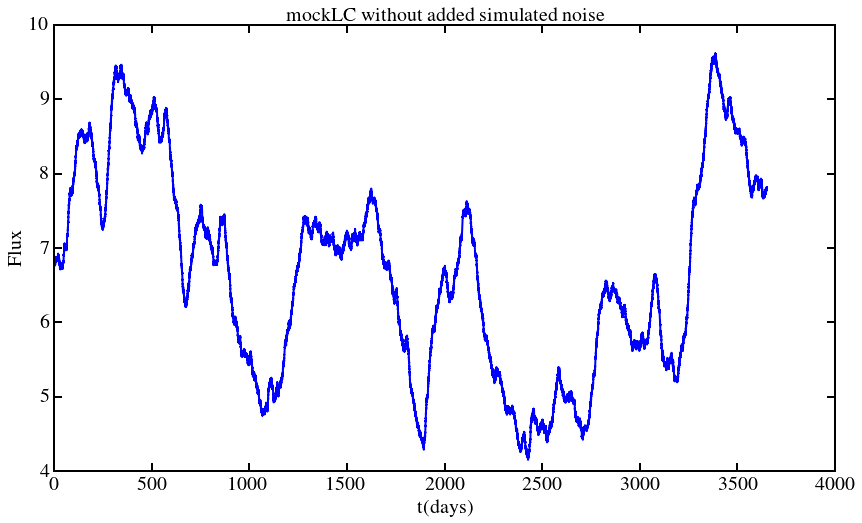

In [7]:
# now plot the mock lc
f = plt.figure(figsize=(14,8))
plt.title('mockLC without added simulated noise')
plt.ylabel('Flux')
plt.xlabel('t(days)')

# np.mean(LC.y) - np.mean(LC.x) gives the mean flux
plt.plot(LC.t, LC.x - np.mean(LC.x) + np.mean(LC.y))

In [8]:
# down sample the mock lc based on pointing history
# lsstlc is the derived subclass of lc object
dLC = lsstlc(pos_gap[0], pos_gap[1], obsHist['expDate'], LC, pos_gap[2])

(0, 2000)

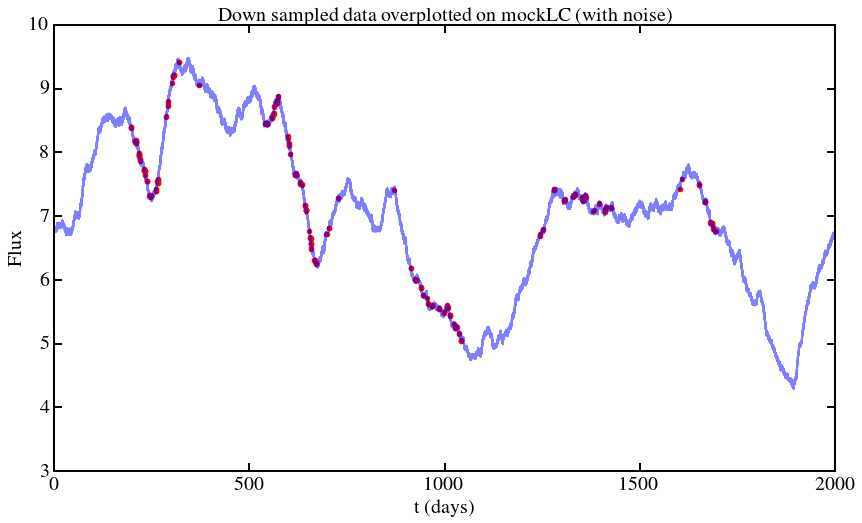

In [9]:
# now plot down sampled data on top of orginal mock lc
pts = dLC.plot_x_y_err() # get arguments for plot
f = plt.figure(figsize=(14,8))
plt.title('Down sampled data overplotted on mockLC (with noise)')
plt.ylabel('Flux')
plt.xlabel('t (days)')
plt.scatter(pts[2], pts[3], color='r')
plt.plot(dLC.mockLC.t, dLC.mockLC.y, alpha=0.5)
plt.xlim(0,2000)

### Fit down-sampled light curve with CARMA(2,1)

In [10]:
# Find the best fit coefficients and print result
Task.fit(dLC)

0

In [11]:
print ('Best fit roots: \n'+ '{}'.format(Task.bestRho))
print ('Original roots: {}'.format(Rho))
print ('Best fit coefficients: \n'+ '{}'.format(Task.bestTheta))
print ('Original coefficients: {}'.format(Theta))

Best fit roots: 
[-0.02781172+0.j -0.01101851+0.j -0.24437646+0.j  1.12905508+0.j]
Original roots: [-0.00927644+0.j -0.03012048+0.j -0.18181818+0.j  1.00000000+0.j]
Best fit coefficients: 
[ 0.03883023  0.00030644  0.00549388  0.02248121]
Original coefficients: [ 0.03939692  0.00027941  0.0046724   0.0256982 ]
